In [1]:
# Add all necessary imports here
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
%matplotlib inline

plt.style.reload_library()
plt.style.use("ggplot")
import math
from numpy.random import *
import seaborn as sns
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV,  RandomizedSearchCV
from sklearn import linear_model, datasets, decomposition
from sklearn.linear_model import LogisticRegressionCV, LinearRegression, LogisticRegression
from sklearn.svm.classes import SVC, OneClassSVM
from sklearn.cross_validation import KFold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, KernelCenterer
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.neural_network import MLPClassifier
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import graphviz
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=3)
np.random.seed(42)

#plt.xkcd()

/Users/stas/anaconda3/envs/mspell/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# utility function to plot the decision surface
def plot_surface(est, x_1, x_2, ax=None, threshold=0.0, contourf=False):
    """Plots the decision surface of ``est`` on features ``x1`` and ``x2``. """
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))
    # plot the hyperplane by evaluating the parameters on the grid
    X_pred = np.c_[xx1.ravel(), xx2.ravel()]  # convert 2d grid into seq of points
    if hasattr(est, 'predict_proba'):  # check if ``est`` supports probabilities
        # take probability of positive class
        pred = est.predict_proba(X_pred)[:, 1]
    else:
        pred = est.predict(X_pred)
    Z = pred.reshape((100, 100))  # reshape seq to grid
    if ax is None:
        ax = plt.gca()
    # plot line via contour plot

    if contourf:
        ax.contourf(xx1, xx2, Z, levels=np.linspace(0, 1.0, 10), cmap=plt.cm.coolwarm, alpha=0.6)
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='grey')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))
    
    
    
def plot_data(x, y, model=None, label_x="x", label_y="y"):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1, 1, 1)

    x0 = x.ix[:,0]
    x1 = x.ix[:,1]
    
    left = plt.scatter(x0[y==1], x1[y==1], color='r', marker='o')
    stayed = plt.scatter(x0[y==0], x1[y==0], color='g', marker='o')
            
    plt.xlabel(label_x)
    plt.ylabel(label_y)

#     plt.legend((left, stayed),
#            ('positive', 'negative'),
#            scatterpoints=1,
#            loc='lower left',
#            ncol=3,
#            fontsize=8)
    
    if model:
        plot_surface(model, x0, x1, threshold=0.5, contourf=True)
        
    plt.show()

## Machine learning

## Regression

In [3]:
n = 50
x = np.linspace(10, 100, n)
t = x * 2
noise = 40 * np.random.rand(n) - 20
y = t + noise
solutions = np.random.rand(3) * 1.3 + 1

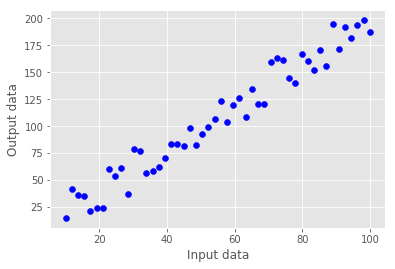

In [4]:
plt.scatter(x, y, color='b')
plt.xlabel('Input data')
plt.ylabel('Output data');

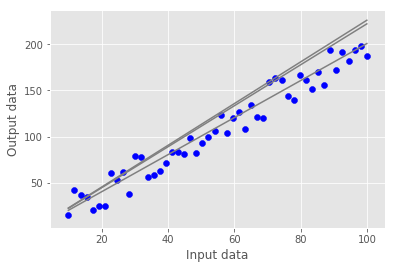

In [5]:
for s in solutions:
    plt.plot(x, s * x, color='grey')

plt.scatter(x, y, color='b')
plt.xlabel('Input data')
plt.ylabel('Output data');

## We need to measure an error

So we will be able to compare models by how well they fit a data.

In [6]:
class MeanSquareError:
    def calc(self, x, y, p):
        # error = (y - px)^2
        return np.mean((y - p * x)**2) 

In [7]:
class MeanSquareError:
    def calc(self, x, y, p):
        # error = (y - px)^2
        return np.mean((y - p * x)**2) 
    
    def der(self, x, y, p):
        # d(error)/dp = -2x(y - px)
        return np.mean(-2.* x * (y - p * x))
    
    def der2(self, x, y, p):
        # d^2(error)/dp^2 = 2x^2
        return np.mean(2*x**2)

In [8]:
class NewtonOptimizer():
    def __init__(self, err):
        self.err = err
    
    def optimize(self, x, y):
        p = 1
        while True:
            next_p = p - self.err.der(x, y, p) / self.err.der2(x, y, p)
            if abs(p - next_p) < 1e-4:
                return p
            p = next_p

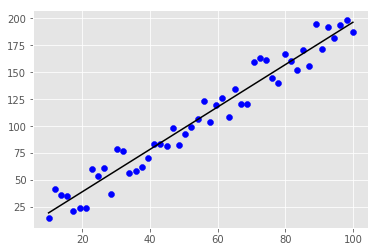

In [9]:
mse = MeanSquareError()
optimizer = NewtonOptimizer(mse)
optimal_p = optimizer.optimize(x, y)

plt.scatter(x, y, color='b')
plt.plot(x, optimal_p * x, color='k');

F(x) = 1.97 * x


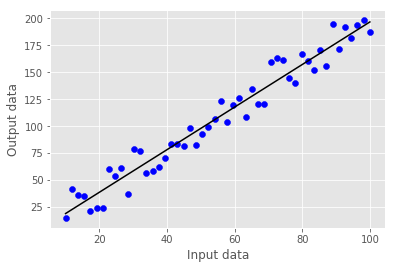

In [10]:
x_vec = x.reshape(len(x), 1)
regression = LinearRegression()
regression.fit(x_vec, y)

plt.scatter(x, y, color='b')
plt.plot(x, regression.predict(x_vec), color='k')
plt.xlabel('Input data'); plt.ylabel('Output data')
print(f'F(x) = {regression.coef_[0]:.2f} * x');

### Algorithm

* Initialize parameter(s) with some random state (p = 42)
* Calculate an error/cost for a function with this parameter
* Change parameter, so error/cost will decrease 
* Repeat until error/cost stop decreasing

### Minimizing an error function

![minimize.gif](img/minimize.gif)

### Classification

In [11]:
n = 400
x1 = np.random.rand(n) * 200 - 100
x2 = np.random.rand(n) * 200 - 100
x = pd.DataFrame()
x['x1'] = x1
x['x2'] = x2
y = (x1+x2 + 50 * np.random.rand(n) - 25) > 0

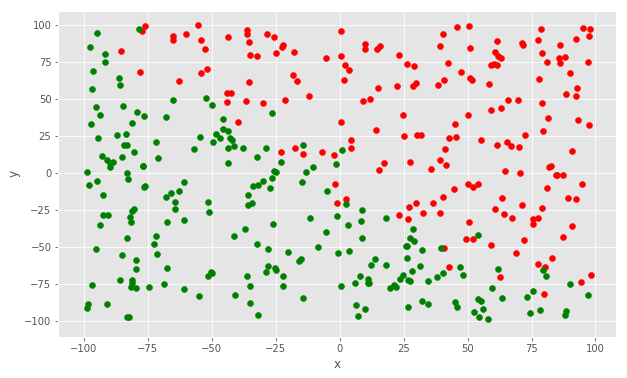

In [12]:
plot_data(x, y)

### Using regression for classification

* Using the same approach from optimization
* Different error measure
* Map output of regression into probability: [0,1]

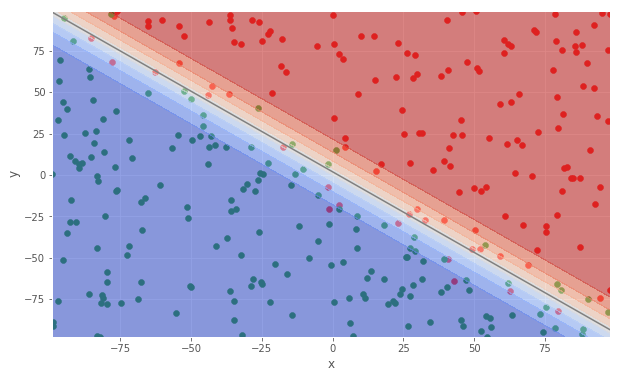

In [13]:
train, test, train_y, test_y = train_test_split(x, y, test_size=0.2)
regression = LogisticRegression()
regression.fit(train, train_y);
plot_data(train, train_y, regression)

### What if data is not easly separable?

In [14]:
n = 400
x1 = np.random.rand(n) * 200 - 100
x2 = np.random.rand(n) * 200 - 100
x = pd.DataFrame()
x['x1'] = x1
x['x2'] = x2
y = (x2 > abs(x1)) | (x2 < -abs(x1))

train, test, train_y, test_y = train_test_split(x, y, test_size=0.2)

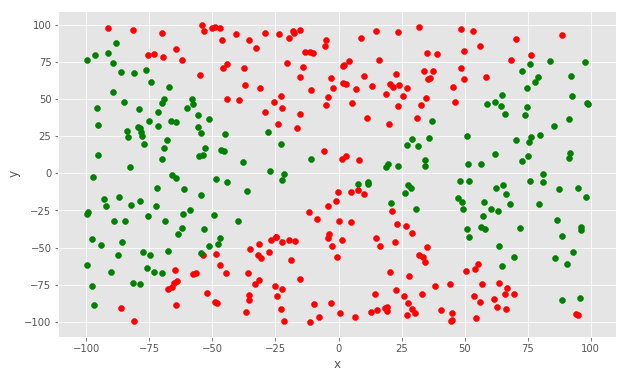

In [15]:
plot_data(x, y)

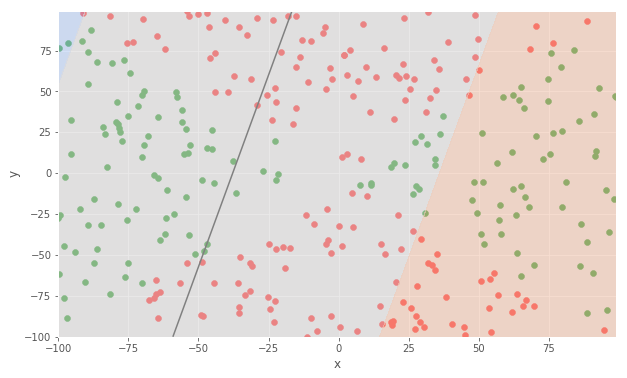

In [16]:
regression = LogisticRegression()
regression.fit(train, train_y);
plot_data(train, train_y, regression)

In [17]:
train["x1^2"] = train["x1"] ** 2
train["x2^2"] = train["x2"] ** 2

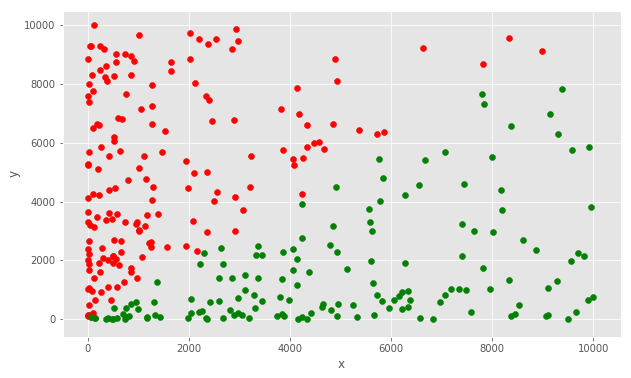

In [18]:
plot_data(train[["x1^2", "x2^2"]], train_y)

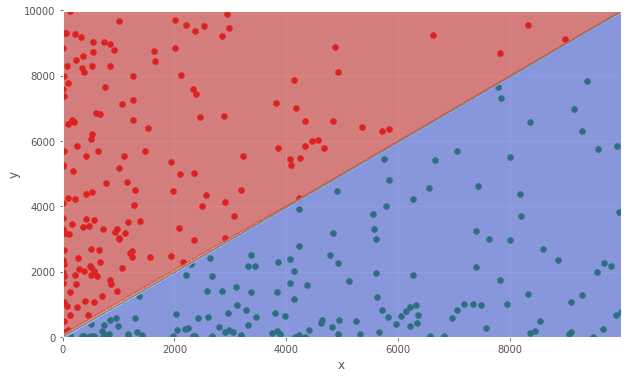

In [19]:
new_train = train[["x1^2", "x2^2"]]
regression = LogisticRegression()
regression.fit(new_train, train_y);
plot_data(new_train, train_y, regression)

In [20]:
train, test, train_y, test_y = train_test_split(x, y, test_size=0.2)
polynomial_features = PolynomialFeatures(degree=2)
new_test = pd.DataFrame(polynomial_features.fit_transform(test), index=test.index)

In [21]:
polynomial_features = PolynomialFeatures(degree=2)
new_train = pd.DataFrame(polynomial_features.fit_transform(train), index=train.index)
new_train.columns = ['1', 'x1', 'x2', 'x1^2','x1 * x2', 'x2^2']
print(new_train.head().to_string(index=False))

1    x1    x2     x1^2  x1 * x2     x2^2
1.00 -9.98 80.72    99.50  -805.21 6,515.97
1.00  8.80 91.16    77.50   802.55 8,311.04
1.00 50.97 24.89 2,597.69 1,268.33   619.27
1.00 -2.32 57.35     5.39  -133.12 3,289.03
1.00  2.02 72.58     4.09   146.74 5,267.29


In [22]:
regression = LogisticRegression()
regression.fit(new_train, train_y)
print(f"Testing accuracy: {accuracy_score(test_y, regression.predict(new_test)):.3f}")

Testing accuracy: 1.000


In [23]:
n = 400

def genSpiral(deltaT, label, m): 
    x1 = np.array([])
    x2 = np.array([])
    y = np.array([])
    for i in range(m):
        r = i / m * 10;
        t = 1.75 * i / m * 2 * math.pi + deltaT;
        x1 = np.append(x1, r * math.sin(t) + random()*2-1 * .03)
        x2 = np.append(x2, r * math.cos(t) + random()*2-1 * .03)
        y = np.append(y, label)  
    return x1, x2, y

x1, x2, y = genSpiral(0, 1, 200); 
x1_2, x2_2, y_2 = genSpiral(math.pi, 0, 200);

x = pd.DataFrame()

x['x1'] = np.append(x1, x1_2)
x['x2'] = np.append(x2, x2_2)
y = np.append(y, y_2)

train, test, train_y, test_y = train_test_split(x, y, test_size=0.2)


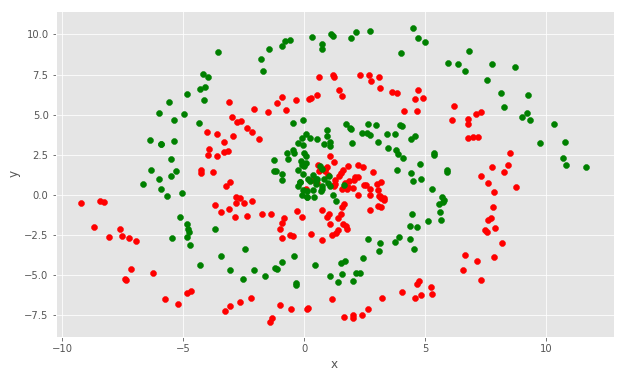

In [24]:
plot_data(x, y)

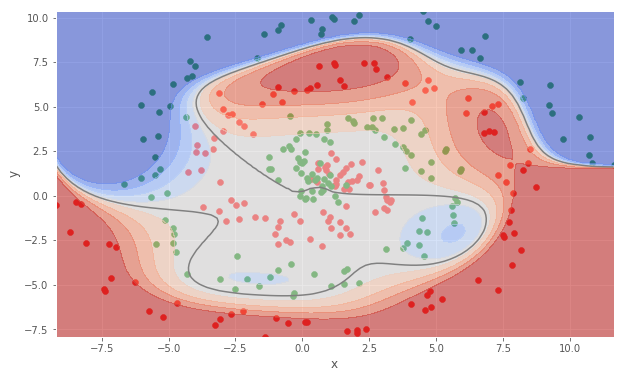

In [25]:
regression = LogisticRegression(C=0.01)
model = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=8)),
    ('regression', regression)])
model.fit(train, train_y);
plot_data(train, train_y, model)

In [26]:
print(f"Training accuracy: {accuracy_score(train_y, model.predict(train)):.3f}")
print(f"Testing accuracy: {accuracy_score(test_y, model.predict(test)):.3f}")

Training accuracy: 0.637
Testing accuracy: 0.537


### Regularization

In [27]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [28]:
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

def show_overfitting():
    np.random.seed(0)

    n_samples = 30
    degrees = [1, 4, 15]

    X = np.sort(np.random.rand(n_samples))
    y = true_fun(X) + np.random.randn(n_samples) * 0.1

    plt.figure(figsize=(14, 5))
    for i in range(len(degrees)):
        ax = plt.subplot(1, len(degrees), i + 1)
        plt.setp(ax, xticks=(), yticks=())

        polynomial_features = PolynomialFeatures(degree=degrees[i],
                                                 include_bias=False)
        linear_regression = LinearRegression()
        pipeline = Pipeline([("polynomial_features", polynomial_features),
                             ("linear_regression", linear_regression)])
        pipeline.fit(X[:, np.newaxis], y)

        # Evaluate the models using crossvalidation
        scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                                 scoring="neg_mean_squared_error", cv=10)

        X_test = np.linspace(0, 1, 100)
        plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
        plt.plot(X_test, true_fun(X_test), label="True function")
        plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xlim((0, 1))
        plt.ylim((-2, 2))
        plt.legend(loc="best")

    plt.show()

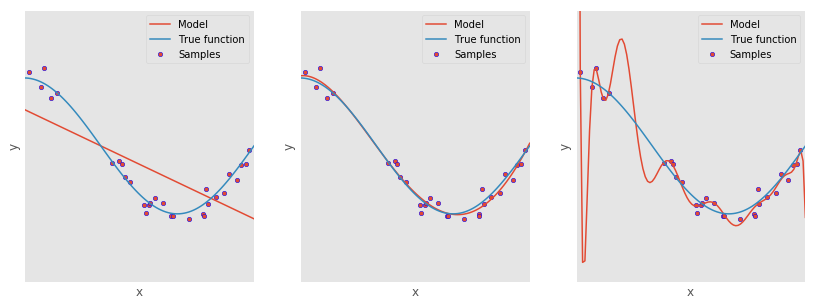

In [29]:
show_overfitting()

### So what is regularization?

* It's a penalty for parameters 
* Adding penalty to the cost function:
```
    Cost = MSE(y, f(w)) + 1/C * sum(w),
    where f(x) = w*x
```
* Bigger parameter - larger cost function
* Optimizator will minimize parameters


### Two main types of regularization

* L1 or `sum(|w|)` - will push parameters to zero
* L2 or `sum(w^2)` - will limit parameter growth

### Coming back to the dataset 

* Let's use L1 regularization 
* This will eliminate unuseful polynomial features

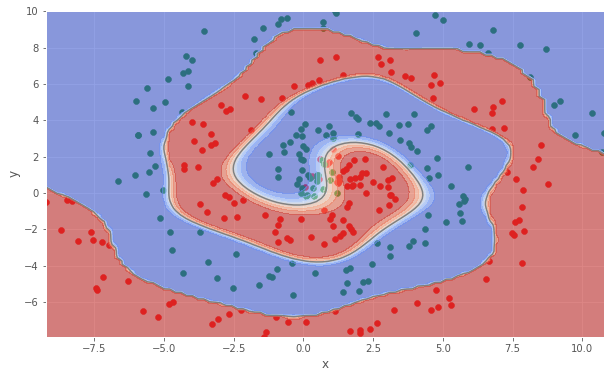

In [30]:
train, test, train_y, test_y = train_test_split(x, y, test_size=0.2)
model = Pipeline(steps=[('poly', PolynomialFeatures(degree=8)),
                  ('linear', LogisticRegression(C=100, penalty='l1'))])
model.fit(train, train_y);
plot_data(train, train_y, model)

In [31]:
print(f"Training accuracy: {accuracy_score(train_y, model.predict(train)):.3f}")
print(f"Testing accuracy: {accuracy_score(test_y, model.predict(test)):.3f}")

Training accuracy: 0.978
Testing accuracy: 0.863


In [32]:
n = 500
x1 = np.random.rand(n) * 200 - 100
x2 = np.random.rand(n) * 200 - 100
y = x1**2 + x2**2 < 50**2
x = pd.DataFrame()
x['x1'] = x1
x['x2'] = x2

train, test, train_y, test_y = train_test_split(x, y, test_size=0.2)

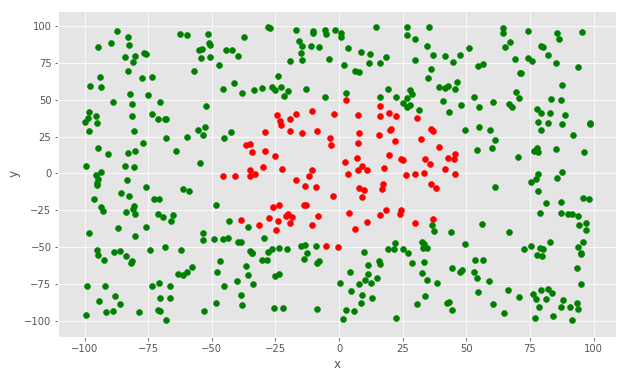

In [33]:
plot_data(x, y)

In [34]:
# Let's use Radial basis function
# as a separate feature
gamma = 0.0005
x['gaussian'] = np.exp(- gamma * (x1**2 + x2**2))

In [35]:
def plot3d(x, y, z, model=None):
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
  

    surf = ax.plot_trisurf(x, y, z,  cmap=cm.coolwarm,
            linewidth=0, antialiased=True)
    #ax.set_zlim(0, 0.2)

    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    fig.colorbar(surf, shrink=0.5, aspect=5)
    if model:
        w = model.coef_[0]
        b = model.intercept_
        X, Y = np.meshgrid(np.arange(-100, 100, 0.25), 
                           np.arange(-100, 100, 0.25))
        Z = (w[0]*X + w[1]*Y + b) / -w[2]
        surf2 = ax.plot_surface(X, Y, Z, alpha=.3,
            linewidth=0, antialiased=True, cmap='summer')

   
    plt.show()


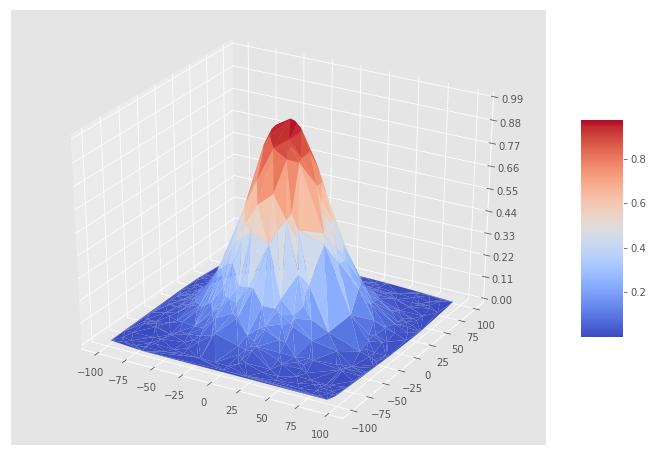

In [36]:
plot3d(x['x1'], x['x2'], x['gaussian'])

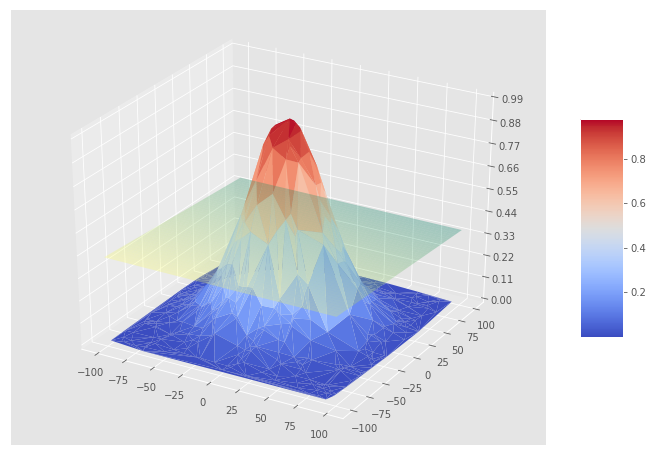

In [37]:
train, test, train_y, test_y = train_test_split(x, y, test_size=0.2)
logistic = LogisticRegression()
logistic.fit(train, train_y);
plot3d(x['x1'], x['x2'], x['gaussian'], logistic)

### SVM

* Linear model
* Transforms data into higher dimentions 
* More efficient than manual transform
* Optimizes margin between classes

In [38]:
n = 500
x1 = np.random.rand(n) * 200 - 100
x2 = np.random.rand(n) * 200 - 100
y = x1**2 + x2**2 < 50**2
x = pd.DataFrame()
x['x1'] = x1
x['x2'] = x2

train, test, train_y, test_y = train_test_split(x, y, test_size=0.2)

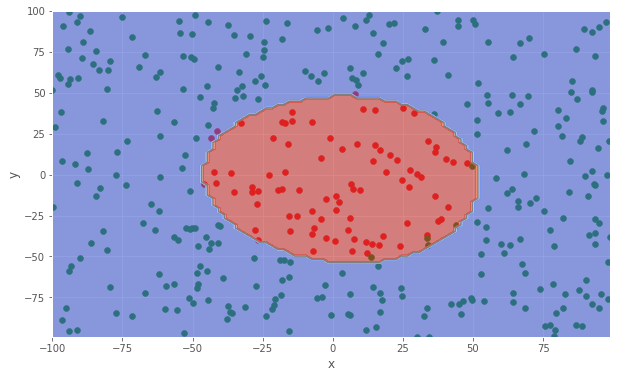

In [39]:
model = SVC(gamma=0.0001)
model.fit(train, train_y)
plot_data(train, train_y, model)

## Let's try some real problem

![kaggle.png](img/kaggle.png)

In [40]:
data = pd.read_csv('../data/HR_comma_sep.csv', index_col=None)
train, test = train_test_split(data, test_size=0.2)

features_used = ['average_montly_hours',
                 'satisfaction_level',
#                  'number_project',
#                  'last_evaluation',
#                  'time_spend_company',
#                  'Work_accident'
                ]

X = train[features_used]
y = train['left']

Xy = X.join(y).sample(frac=1)

In [41]:
print(Xy.head().to_string(index=False))

average_montly_hours  satisfaction_level  left
                 243                0.63     0
                 169                0.76     0
                 267                0.50     0
                 167                0.20     0
                 145                0.60     0


In [43]:
sub_sample = random_sample(len(X)) > 0.95
small_X = X[sub_sample]
small_y = y[sub_sample]

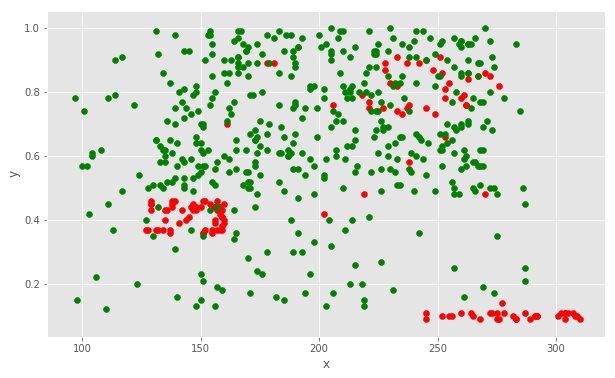

In [44]:
plot_data(small_X, small_y)

In [45]:
class ConfidentClassifier:
    def decision_function(self, X):
        return [1.0 if x else -1.0 for x in self.predict(X)]

In [46]:
class NaiveClassifier(ConfidentClassifier):
    def predict(self, X):
        amh = X['average_montly_hours']
        sl = X['satisfaction_level']
        return ((amh > 250) & (sl < .85)) | ((amh < 160) & (sl > .3) & (sl < .5))  

In [47]:
def performance(model, dataset):
    # test set is 20% of all data 
    expected = dataset['left']==1
    prediction = model.predict(dataset[features_used])
    model_name = model.__class__.__name__
    print(f"Accuracy of {model_name}: {accuracy_score(expected, prediction)}")

In [48]:
performance(NaiveClassifier(), test)

Accuracy of NaiveClassifier: 0.8056666666666666


In [49]:
class OptimisticHR(ConfidentClassifier):
    def predict(self, X):
        return np.zeros(len(X)) # never predicts that person leave

performance(OptimisticHR(), test)

Accuracy of OptimisticHR: 0.7616666666666667


In [50]:
class PessimisticHR(ConfidentClassifier):
    def predict(self, X):
        return np.ones(len(X)) # predicts that every person leaves
    
performance(PessimisticHR(), test)

Accuracy of PessimisticHR: 0.23833333333333334


In [51]:
class FairCoin(ConfidentClassifier):
    def predict(self, X):
        return np.random.randint(2, size=len(X))
    
performance(FairCoin(), test)

Accuracy of FairCoin: 0.49866666666666665


In [52]:
def performance(model, dataset):
    expected = dataset['left']==1
    prediction = model.predict(dataset[features_used])
    model_name = model.__class__.__name__
    print(f"Accuracy of {model_name}: {accuracy_score(expected, prediction)}")
    print(f"Classification report for {model_name}:\n {classification_report(expected, prediction)}")

In [53]:
performance(NaiveClassifier(), test)

Accuracy of NaiveClassifier: 0.8056666666666666
Classification report for NaiveClassifier:
              precision    recall  f1-score   support

      False       0.91      0.83      0.87      2285
       True       0.57      0.73      0.64       715

avg / total       0.83      0.81      0.81      3000



![pr](img/precisionrecall.png)

![f1](img/f1.png)

In [54]:
performance(OptimisticHR(), test)

Accuracy of OptimisticHR: 0.7616666666666667
Classification report for OptimisticHR:
              precision    recall  f1-score   support

      False       0.76      1.00      0.86      2285
       True       0.00      0.00      0.00       715

avg / total       0.58      0.76      0.66      3000



In [55]:
# Compute ROC curve and ROC area for each class
def plot_roc_curve(model, dataset):
    y_score = model.decision_function(dataset[features_used])
    fpr, tpr, _ = roc_curve(dataset['left'] == 1, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

## Area under receiver operating characteristic curve (ROC curve)
![roc.png](img/roc.png)

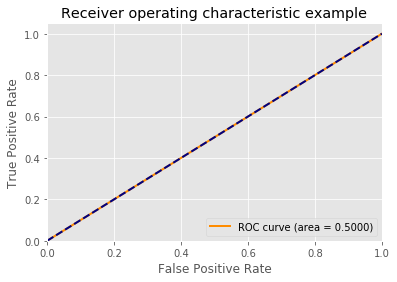

In [56]:
plot_roc_curve(OptimisticHR(), test)

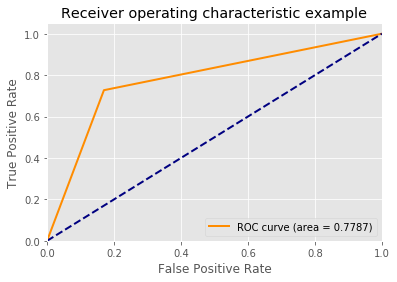

In [57]:
plot_roc_curve(NaiveClassifier(), test)

## Let's use logistic regresion

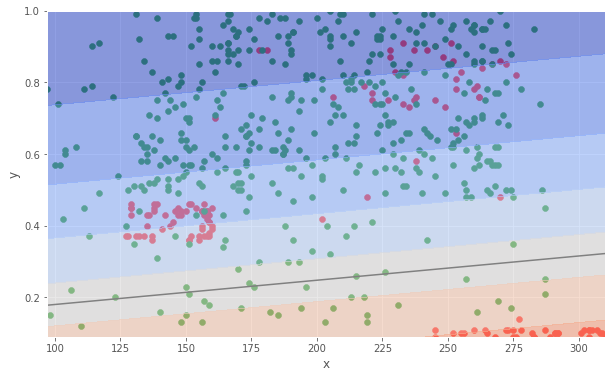

In [58]:
regression = LogisticRegression()
regression.fit(train[features_used], train['left'])
plot_data(small_X, small_y, regression)

In [59]:
performance(regression, test)

Accuracy of LogisticRegression: 0.7713333333333333
Classification report for LogisticRegression:
              precision    recall  f1-score   support

      False       0.80      0.93      0.86      2285
       True       0.54      0.26      0.36       715

avg / total       0.74      0.77      0.74      3000



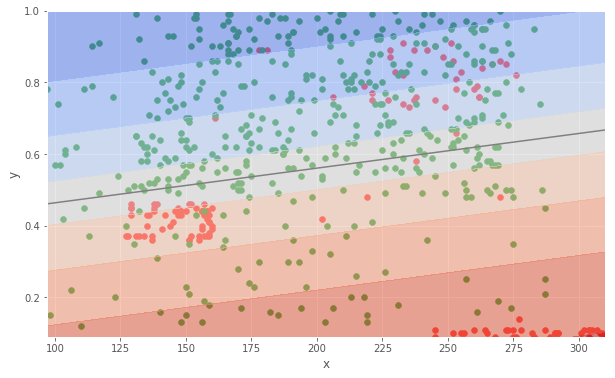

In [60]:
regression = LogisticRegression(class_weight='balanced')
regression.fit(train[features_used], train['left'])

plot_data(small_X, small_y, regression)

In [61]:
performance(regression, test)

Accuracy of LogisticRegression: 0.7183333333333334
Classification report for LogisticRegression:
              precision    recall  f1-score   support

      False       0.89      0.71      0.79      2285
       True       0.44      0.73      0.55       715

avg / total       0.79      0.72      0.74      3000



In [62]:
polynomial_features = PolynomialFeatures(degree=2)
regression = LogisticRegression(class_weight='balanced')
pipe = Pipeline(steps=[
    ('polynomial_features', polynomial_features), 
    ('regression', regression)
])
pipe.fit(train[features_used], train['left']);

In [63]:
performance(pipe, test)

Accuracy of Pipeline: 0.736
Classification report for Pipeline:
              precision    recall  f1-score   support

      False       0.88      0.75      0.81      2285
       True       0.46      0.69      0.55       715

avg / total       0.78      0.74      0.75      3000



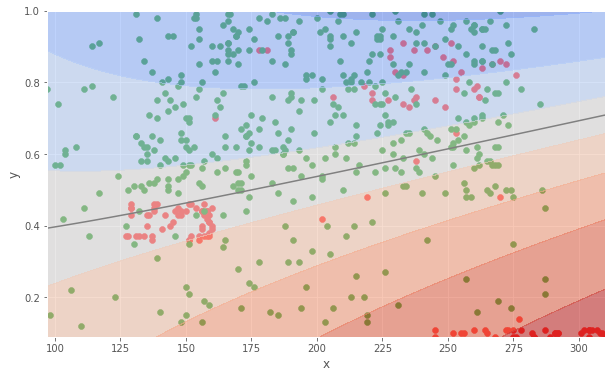

In [64]:
plot_data(small_X, small_y, pipe)

In [65]:
# Cross-validation
fold = KFold(len(train), n_folds=5, shuffle=True)

In [66]:
polynomial_features = PolynomialFeatures()
logistic = linear_model.LogisticRegression(class_weight='balanced', max_iter=200)
pipe = Pipeline(steps=[
    ('polynomial', polynomial_features), 
    ('logistic', logistic)
])

In [67]:
# All possible parameters
Cs = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
degrees = [2,3,4]
penalties = ['l1','l2']

In [68]:
estimator = RandomizedSearchCV(
    pipe,
    scoring='roc_auc',
    cv=fold,
    param_distributions=dict(
        polynomial__degree=degrees,
        logistic__C=Cs,
        logistic__penalty=penalties
    )
)

estimator.fit(train[features_used], train['left']);

In [69]:
performance(estimator, train)

Accuracy of RandomizedSearchCV: 0.8062338528210684
Classification report for RandomizedSearchCV:
              precision    recall  f1-score   support

      False       0.93      0.81      0.86      9143
       True       0.57      0.79      0.66      2856

avg / total       0.84      0.81      0.82     11999



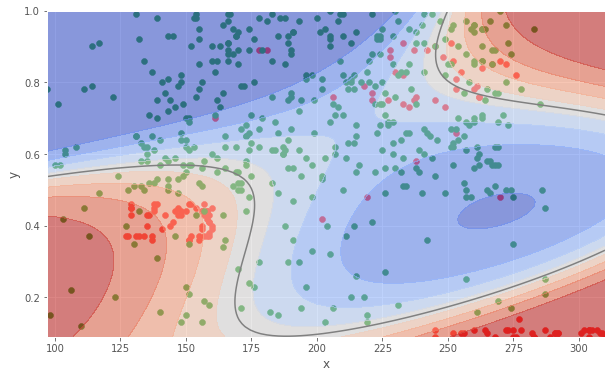

In [70]:
plot_data(small_X, small_y, estimator)

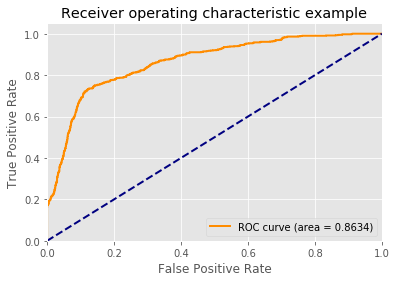

In [71]:
plot_roc_curve(estimator, test)

In [72]:
print(estimator.best_params_)

{'polynomial__degree': 3, 'logistic__penalty': 'l1', 'logistic__C': 10.0}


In [73]:
clf = tree.DecisionTreeClassifier()
clf.fit(train[features_used], train['left']);

In [74]:
performance(clf, test)

Accuracy of DecisionTreeClassifier: 0.9133333333333333
Classification report for DecisionTreeClassifier:
              precision    recall  f1-score   support

      False       0.94      0.95      0.94      2285
       True       0.82      0.81      0.82       715

avg / total       0.91      0.91      0.91      3000



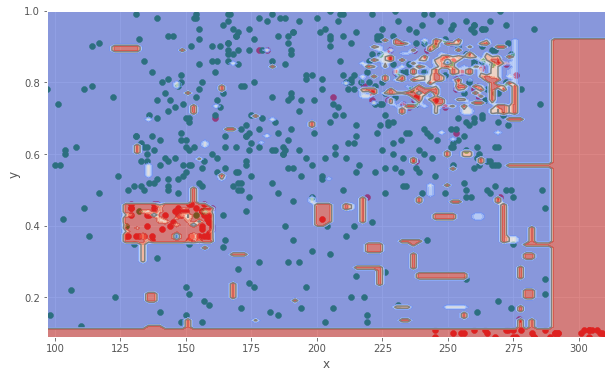

In [75]:
plot_data(small_X, small_y, clf)

In [76]:
performance(clf, train)

Accuracy of DecisionTreeClassifier: 0.9648304025335445
Classification report for DecisionTreeClassifier:
              precision    recall  f1-score   support

      False       0.97      0.98      0.98      9143
       True       0.93      0.92      0.93      2856

avg / total       0.96      0.96      0.96     11999



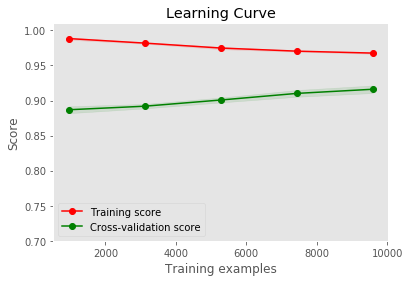

In [77]:
clf = tree.DecisionTreeClassifier()
cv = KFold(len(train), n_folds=5, shuffle=True)
plot_learning_curve(clf, "Learning Curve", train[features_used],  train['left'], ylim=(0.7, 1.01), cv=cv);

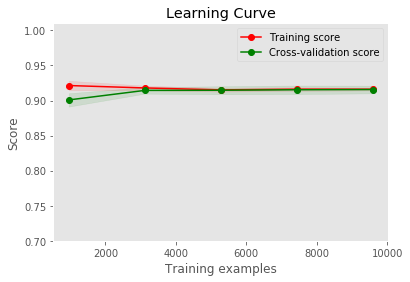

In [78]:
clf = tree.DecisionTreeClassifier(max_depth=5)
cv = KFold(len(train), n_folds=5, shuffle=True)
plot_learning_curve(clf, "Learning Curve", train[features_used], train['left'], ylim=(0.7, 1.01), cv=cv);

In [79]:
clf.fit(train[features_used], train['left']);
performance(clf, train)

Accuracy of DecisionTreeClassifier: 0.9159096591382615
Classification report for DecisionTreeClassifier:
              precision    recall  f1-score   support

      False       0.91      0.99      0.95      9143
       True       0.95      0.68      0.79      2856

avg / total       0.92      0.92      0.91     11999



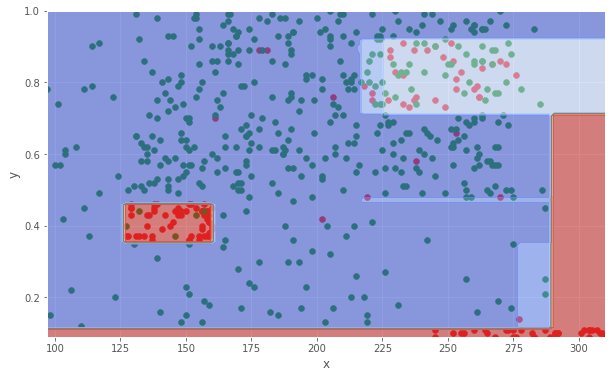

In [80]:
plot_data(small_X, small_y, clf)

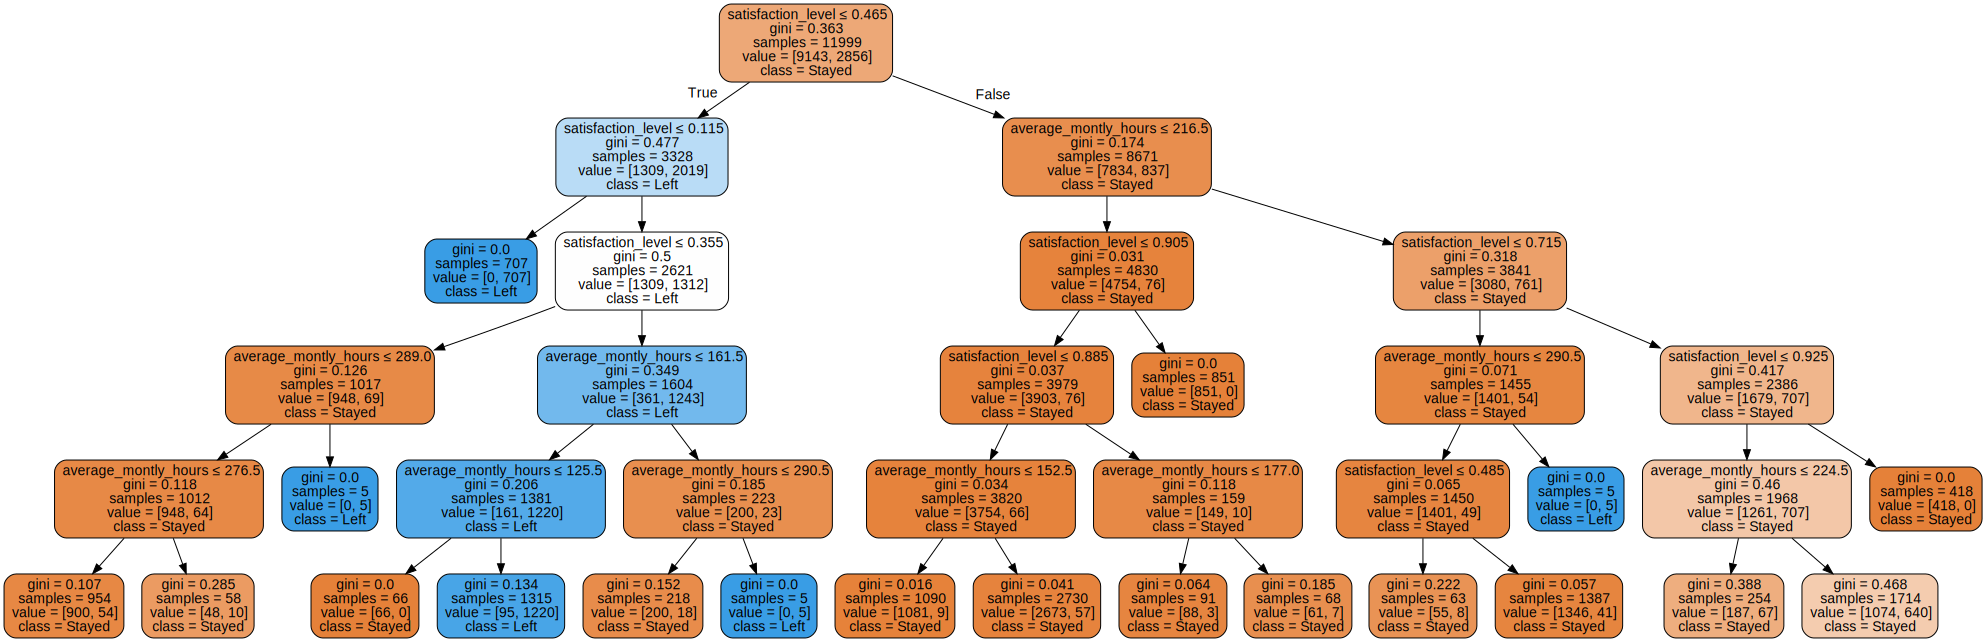

In [81]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=['average_montly_hours','satisfaction_level'],  
                         class_names=['Stayed', 'Left'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
g = graphviz.Source(dot_data)  
g

![tree1](img/dtree1.png)

![tree1](img/dtree2.png)

In [82]:
train['proj_time'] = train['number_project']/train['time_spend_company']
test['proj_time'] = test['number_project']/test['time_spend_company']

features_used = ['average_montly_hours',
                 'satisfaction_level',
                 'number_project',
                 'proj_time',
                 'last_evaluation',
                 'time_spend_company',
                 'Work_accident', 
                ]

X = train[features_used]
y = train['left']

sub_sample = random_sample(len(X)) > 0.98
small_X = X[sub_sample]
small_y = y[sub_sample]

Xy = X.join(y).sample(frac=1)

### What about more than two dimentions?

In [83]:
print(X.head().to_string(index=False))

average_montly_hours  satisfaction_level  number_project  proj_time  last_evaluation  time_spend_company  Work_accident
                 148                0.66               5       1.67             0.67                   3              0
                 237                0.24               6       1.20             0.94                   5              0
                 181                0.80               5       1.25             0.74                   4              1
                 136                0.43               2       0.67             0.52                   3              0
                 236                0.78               5       1.67             0.59                   3              0


### Getting rid of useless features

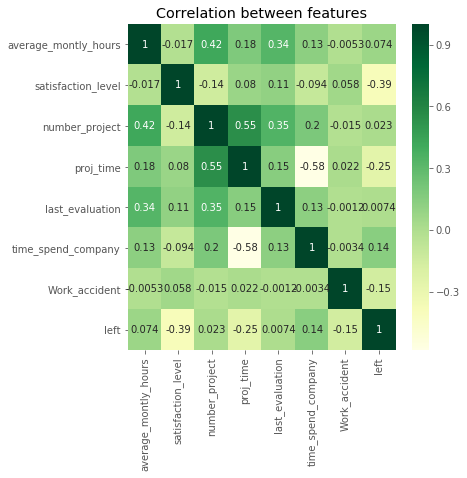

In [84]:
plt.figure(figsize=(6,6))
sns.heatmap(Xy.corr(), vmax=1.0, annot=True, cmap='YlGn')
plt.title('Correlation between features');

In [85]:
clf = tree.DecisionTreeClassifier(criterion="entropy")
clf.fit(X, y);

In [86]:
performance(clf, test)

Accuracy of DecisionTreeClassifier: 0.9783333333333334
Classification report for DecisionTreeClassifier:
              precision    recall  f1-score   support

      False       0.99      0.98      0.99      2285
       True       0.95      0.97      0.96       715

avg / total       0.98      0.98      0.98      3000



In [87]:
[print(f"Importance({x}) = {y}") for x, y in zip (features_used, clf.feature_importances_)];

Importance(average_montly_hours) = 0.09749732959786923
Importance(satisfaction_level) = 0.36578408897238224
Importance(number_project) = 0.16971783933848011
Importance(proj_time) = 0.04706838480570836
Importance(last_evaluation) = 0.14122852989767742
Importance(time_spend_company) = 0.17589698428257974
Importance(Work_accident) = 0.002806843105303003


### How to visualize

In [88]:
scaler = StandardScaler()
pca = PCA(n_components=2)
dim_reducer = Pipeline(steps=[('scaler', scaler), ('pca', pca)])
dim_reducer.fit(X);

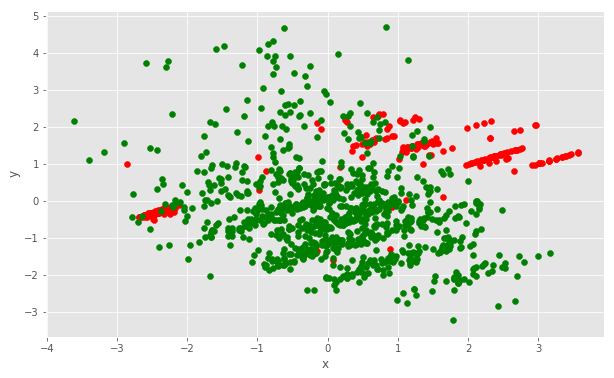

In [89]:
transformed = pd.DataFrame(dim_reducer.transform(X), index=train.index)
sample_10perc = random_sample(len(X)) > 0.9
plot_data(transformed[sample_10perc], y[sample_10perc]);

In [90]:
polynomial_features = PolynomialFeatures(4)
logistic = linear_model.LogisticRegression(
    class_weight='balanced', 
    penalty='l1', 
    C=10, 
    max_iter=500
)

In [91]:
model = Pipeline(steps=[
    ('polynomial_features', polynomial_features),
    ('logistic', logistic)
])

In [92]:
pipe = Pipeline(steps=[
    ('dim_reducer', dim_reducer),
    ('model', model)])
pipe.fit(X, y);

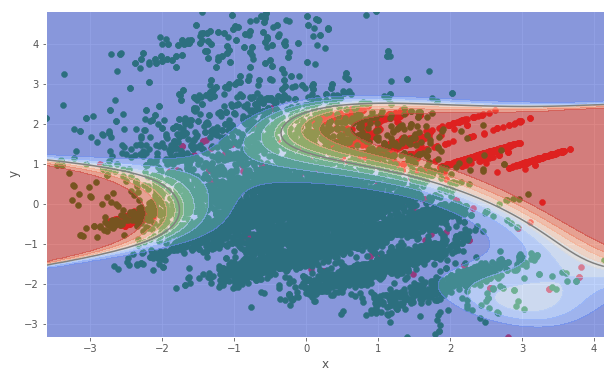

In [93]:
transformed = pd.DataFrame(dim_reducer.transform(X), index=train.index)
plot_data(transformed, y, model);

In [94]:
performance(pipe, test)

Accuracy of Pipeline: 0.9303333333333333
Classification report for Pipeline:
              precision    recall  f1-score   support

      False       0.98      0.93      0.95      2285
       True       0.81      0.92      0.86       715

avg / total       0.94      0.93      0.93      3000



## Summary

* Know your data
* Visualize everything 
* Start from simple models
* Choose right metrics for evaluation
* Simple heristics are usually good start